### Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn import metrics, model_selection, tree, ensemble
%matplotlib inline

In [2]:
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')
test = pd.read_csv('assets/west-nile-test.csv')
train = pd.read_csv('assets/west-nile-train.csv')

### Datetime Transformations

In [4]:
spray.Date = pd.to_datetime(spray.Date, format='%Y-%m-%d')
train.Date = pd.to_datetime(train.Date, format='%Y-%m-%d')
test.Date = pd.to_datetime(test.Date, format='%Y-%m-%d')
weather.Date = pd.to_datetime(weather.Date, format='%Y-%m-%d')

### Weather Dataset Wrangling

In [17]:
weather.Tavg = pd.to_numeric(weather.Tavg, errors='coerce')
weather.Depart = pd.to_numeric(weather.Depart, errors='coerce')
weather.WetBulb = pd.to_numeric(weather.WetBulb, errors='coerce')
weather.Heat = pd.to_numeric(weather.Heat, errors='coerce')
weather.Cool = pd.to_numeric(weather.Cool, errors='coerce')
weather.PrecipTotal = pd.to_numeric(weather.PrecipTotal, errors='coerce')
weather.StnPressure = pd.to_numeric(weather.StnPressure, errors='coerce')
weather.SeaLevel = pd.to_numeric(weather.SeaLevel, errors='coerce')
weather.ResultSpeed = pd.to_numeric(weather.ResultSpeed, errors='coerce')
weather.ResultDir = pd.to_numeric(weather.ResultDir, errors='coerce')
weather.AvgSpeed = pd.to_numeric(weather.AvgSpeed, errors='coerce')
weather.Depth = pd.to_numeric(weather.Depth, errors='coerce')
weather.Water1 = pd.to_numeric(weather.Water1, errors='coerce')
weather.SnowFall = pd.to_numeric(weather.SnowFall, errors='coerce')
weather.Sunset = pd.to_numeric(weather.Sunset, errors='coerce')
weather.Sunrise = pd.to_numeric(weather.Sunrise, errors='coerce')

In [6]:
def avg_wind_direction(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    elif np.abs(S1-S2) > 18:
        if S1<S2:
            S1+=36
        else:
            S2+=36
        avg = (S1+S2)/2.0
    else:
        avg = (S1+S2)/2.0
    if avg >=36:
        avg-=36
    return avg
def combine_conditions(S1, S2):
    if S1 == " " and S2 == " ":
        return ""
    elif S1 == " " and S2 != " ":
        return S2
    elif S1 != " " and S2 == " ":
        return S1
    else:
        S1_list = S1.split(" ")
        S2_list = S2.split(" ")
        return list(set(S1_list + S2_list))
def avg_col(S1, S2):
   if S1 == np.NaN:
       avg = float(S2)
   elif S2 == np.NaN:
       avg = float(S1)
   else: 
       avg=(S1+S2)/2.0
   return avg

In [20]:
weather_s1 = weather[weather.Station==1]
weather_s2 = weather[weather.Station==2]
weather_both = pd.merge(weather_s1, weather_s2, how='outer', left_on='Date', right_on='Date').dropna(axis=1, how='all').drop(['Station_x', 'Station_y'], axis=1)

In [22]:
weather_both['month'] = weather_both.Date.dt.month
weather_both['day'] = weather_both.Date.dt.day

In [36]:
weather_both['day_length'] = weather_both.Sunset_x - weather_both.Sunrise_x

In [26]:
weather_both_dropna = weather_both.dropna()

### Train/Test Data Wrangling

In [35]:
train['day'] = train.Date.dt.day
train['month'] = train.Date.dt.month
train['day_of_week'] = train.Date.dt.dayofweek
train_good = train.drop(['Address', 'AddressNumberAndStreet'], axis=1)

### Merge

In [41]:
merged = pd.merge(train_good, weather_both, how='inner', left_on='Date', right_on='Date')

In [55]:
merged2 = pd.get_dummies(merged).dropna()

In [61]:
X = merged2.drop(['WnvPresent', 'NumMosquitos', 'Date'], axis=1)
y = merged2.WnvPresent

In [62]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)

clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000)
clf.fit(X_train, y_train)

predict = clf.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.75935851547690425

In [64]:
import xgboost

In [66]:
xgb = xgboost.XGBClassifier(n_estimators=1000)
xgb.fit(X_train, y_train)

predict = xgb.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.80789833875373218

In [196]:
combined_weather = pd.DataFrame()
combined_weather['Date'] = weather.Date[weather.Station==1].values
combined_weather['ResultDir'] = [avg_wind_direction(a, b) for a, b in zip(weather.ResultDir[weather.Station==1].values, weather.ResultDir[weather.Station==2].values)]
combined_weather['CodeSum'] = [combine_conditions(a, b) for a, b in zip(weather.CodeSum[weather.Station==1].values, weather.CodeSum[weather.Station==2].values)]
combined_weather['Depart'] = weather.Depart[weather.Station==1].values
combined_weather['Sunrise'] = weather.Sunrise[weather.Station==1].values
combined_weather['Sunset'] = weather.Sunset[weather.Station==1].values
combined_weather['PrecipTotal_station1'] = weather.PrecipTotal[weather.Station==1].values
combined_weather['PrecipTotal_station2'] = weather.PrecipTotal[weather.Station==2].values
for col in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'AvgSpeed']:
    combined_weather[col] = [avg_col(a, b) for a, b in zip(weather[col][weather.Station==1].values, weather[col][weather.Station==2].values)]

In [357]:
weather_train_merged_clean = weather_train_merged.dropna(subset=['Trap'])

In [358]:
weather_train_merged_clean

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,ResultDir,CodeSum,Depart,Sunrise,Sunset,PrecipTotal_station1,PrecipTotal_station2,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,StnPressure,SeaLevel,ResultSpeed,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62.0,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,4.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15.0,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8.0,2.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25.0,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11.0,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11.0,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8.0,2.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11.0,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8.0,1.0,0.0,17.0,"[HZ, BR]",10.0,0421,1917,0.00,0.00,88.0,62.5,75.5,58.5,65.5,0.0,10.5,29.415,30.100,5.80,6.95


In [374]:
from sklearn import preprocessing

In [553]:
le_trap = preprocessing.LabelEncoder()
weather_train_merged_clean['Trap_num'] = le_trap.fit_transform(weather_train_merged_clean.Trap)

le_species = preprocessing.LabelEncoder()
weather_train_merged_clean['Species_num'] = le_species.fit_transform(weather_train_merged_clean.Species)

le_block = preprocessing.LabelEncoder()
weather_train_merged_clean['Street_num'] = le_species.fit_transform(weather_train_merged_clean.Street)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [574]:
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(weather_train_merged_clean.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

# dummy_trap = pd.get_dummies(weather_train_merged_clean.Trap)

# dummy_species = pd.get_dummies(weather_train_merged_clean.Species)

weather_train_merged_clean_recode1 = pd.concat([weather_train_merged_clean, mlb_df, dummy_trap, dummy_species], axis=1)
weather_train_merged_clean_recode1['month'] = weather_train_merged_clean_recode1.Date.dt.month
weather_train_merged_clean_recode1['day'] = weather_train_merged_clean_recode1.Date.dt.day

In [575]:
weather_train_merged_clean_recode1.Sunrise = pd.to_numeric(weather_train_merged_clean_recode1.Sunrise)
weather_train_merged_clean_recode1.Sunset = pd.to_numeric(weather_train_merged_clean_recode1.Sunset)

In [576]:
weather_train_merged_clean_recode1['Lat_int'] = weather_train_merged_clean_recode1.Latitude.apply(int)
weather_train_merged_clean_recode1['Long_int'] = weather_train_merged_clean_recode1.Longitude.apply(int)

In [602]:
X = weather_train_merged_clean_recode1.drop('StnPressure PrecipTotal_station1 PrecipTotal_station2 Date Trap Species Address Street AddressNumberAndStreet CodeSum NumMosquitos WnvPresent'.split(' '), axis=1).drop(' ', axis=1).fillna({
        'WetBulb':weather_train_merged_clean.WetBulb.mean(),
    })
y = weather_train_merged_clean_recode1.WnvPresent

In [604]:
from sklearn import model_selection, preprocessing, ensemble, metrics

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

0.53471418577434304

In [596]:
print metrics.classification_report(y_test, predict)

             precision    recall  f1-score   support

        0.0       0.95      0.99      0.97      2999
        1.0       0.31      0.08      0.12       153

avg / total       0.92      0.95      0.93      3152



In [406]:
from sklearn import tree

In [421]:
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)
predict = dtree.predict(X_test)
metrics.accuracy_score(y_test, predict)

0.95019035532994922

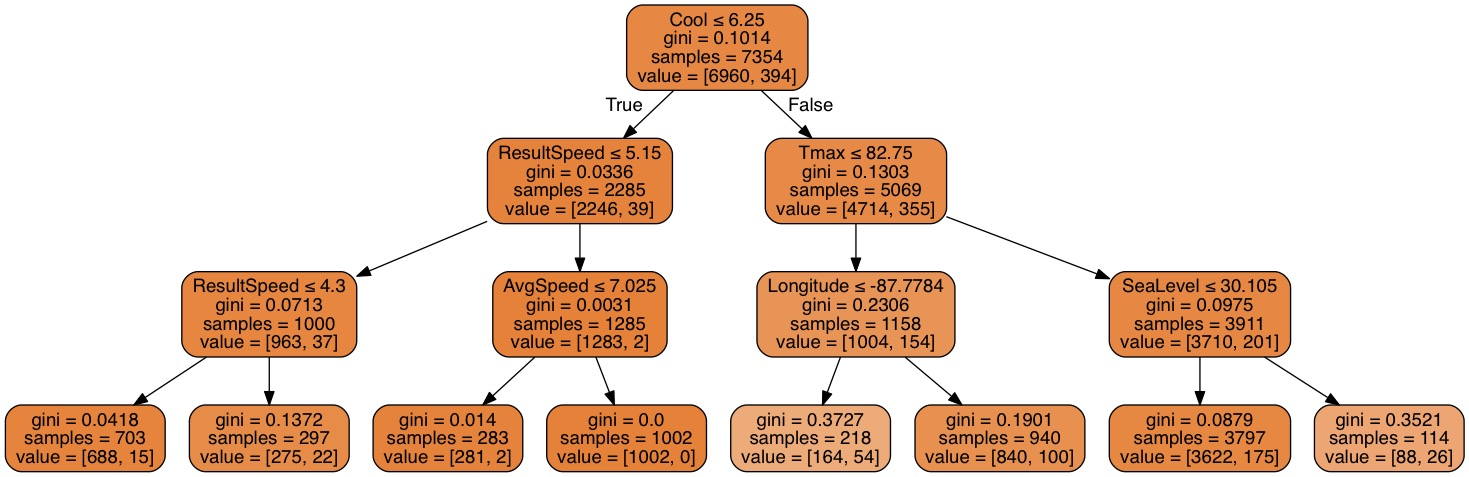

In [422]:
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
dot_data = StringIO()  
tree.export_graphviz(dtree, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_jpg())


In [423]:
print metrics.classification_report(y_test, predict)

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97      2995
        1.0       0.00      0.00      0.00       157

avg / total       0.90      0.95      0.93      3152



In [427]:
test

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
5,6,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TARSALIS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
6,7,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",UNSPECIFIED CULEX,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
7,8,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX ERRATICUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
8,9,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX PIPIENS/RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9
9,10,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9


In [426]:
pd.read_csv('assets/sampleSubmission.csv')

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [440]:
test.Date.min()

Timestamp('2008-06-11 00:00:00')

In [443]:
train.Date.dt.year.value_counts()

2007    3811
2013    2392
2009    2249
2011    2054
Name: Date, dtype: int64

In [444]:
test.Date.dt.year.value_counts()

2010    36557
2008    30498
2012    27115
2014    22123
Name: Date, dtype: int64

In [446]:
spray.Date.dt.year.value_counts()

2013    12626
2011     2209
Name: Date, dtype: int64

In [447]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
